<a href="https://colab.research.google.com/github/callumhedemann/Reinforcement-Learning/blob/master/The_Cross_Entropy_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cross Entropy Method - CartPole 

epoch 0 avg_returns 21.7
epoch 1 avg_returns 33.4
epoch 2 avg_returns 26.3
epoch 3 avg_returns 33.7
epoch 4 avg_returns 38.0
epoch 5 avg_returns 43.6
epoch 6 avg_returns 49.35
epoch 7 avg_returns 46.45
epoch 8 avg_returns 51.4
epoch 9 avg_returns 50.4
epoch 10 avg_returns 55.05
epoch 11 avg_returns 67.25
epoch 12 avg_returns 51.0
epoch 13 avg_returns 60.2
epoch 14 avg_returns 59.95
epoch 15 avg_returns 68.75
epoch 16 avg_returns 77.85
epoch 17 avg_returns 83.65
epoch 18 avg_returns 71.25
epoch 19 avg_returns 77.85
epoch 20 avg_returns 86.3
epoch 21 avg_returns 82.95
epoch 22 avg_returns 101.0
epoch 23 avg_returns 87.15
epoch 24 avg_returns 107.45
epoch 25 avg_returns 100.9
epoch 26 avg_returns 119.8
epoch 27 avg_returns 105.05
epoch 28 avg_returns 112.55
epoch 29 avg_returns 148.75
epoch 30 avg_returns 133.85
epoch 31 avg_returns 133.25
epoch 32 avg_returns 127.7
epoch 33 avg_returns 139.95
epoch 34 avg_returns 146.95
epoch 35 avg_returns 156.6
epoch 36 avg_returns 182.8
epoch 37 avg_r

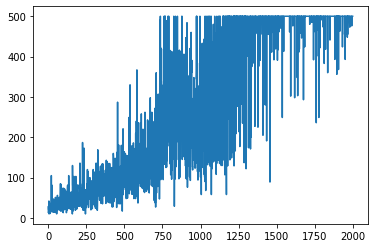

In [1]:
import gym
import time, random, math
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
#from scipy.special import softmax

env = gym.make('CartPole-v1')

batch_percentile = 75
#gamma = 0.99
n_epochs = 100
batch_size = 20
returns, losses = [], []
avg_returns = [0]

class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=256):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        self.fc2 = nn.Linear(hs, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs an action preference for each action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #return F.softmax(self.out(x))
        return self.out(x)

Net = ANN()
optimiser = torch.optim.Adam(Net.parameters(), lr=0.001)#, weight_decay=0.001)

for e in range(n_epochs):
    batch_returns, batch_states, batch_actions = [], [], []
    with torch.no_grad():
        for n in range(batch_size):
            state = env.reset()
            g = 0
            states, actions = [], []
            while True: # generate an episode                
                action_dist = F.softmax(Net(torch.Tensor(state)).detach(), dim=0).numpy()                
                action = np.random.choice(env.action_space.n, p=action_dist) # probabilistic action selection
                observation, reward, done, _ = env.step(action)
                states.append(state)
                actions.append(action)
                g += reward
                state = observation
                if done:
                    batch_returns.append(g)
                    batch_states.append(states)
                    batch_actions.append(actions)
                    returns.append(g)
                    break
    idxs = batch_returns >= np.percentile(batch_returns, batch_percentile)
    train_states = np.concatenate(np.array(batch_states)[idxs])
    train_actions = np.concatenate(np.array(batch_actions)[idxs])
    preds = Net(torch.Tensor(train_states))
    optimiser.zero_grad()
    #print(preds.shape, train_actions.shape)
    loss = F.cross_entropy(preds, torch.Tensor(train_actions).long())
    loss.backward()
    losses.append(loss)
    optimiser.step()
    avg_returns.append(np.mean(returns[-batch_size:])) # diagnostic
    print('epoch', e, 'avg_returns', avg_returns[-1])
            

pd.Series(returns).plot()

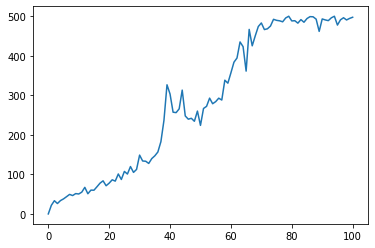

In [2]:
pd.Series(avg_returns).plot()